# Term Deposit Sale

## Background
A dataset collected from existing bank customers sets out demographic and financial details, along with details of previous contacts, and campaign outcomes.

## Data
The project briefing sets out the following description of each attribute.
#### Bank client data:
1. age: Continuous feature
2. job: Type of job (management, technician, entrepreneur, blue-collar, etc.)
3. marital: marital status (married, single, divorced)
4. education: education level (primary, secondary, tertiary)
5. default: has credit in default?
6. housing: has housing loan?
7. loan: has personal loan?
8. balance in account

#### Related to previous contact:
9. contact: contact communication type
10. month: last contact month of year
11. day: last contact day of the month
12. duration: last contact duration, in seconds*

#### Other attributes:
13. campaign: number of contacts performed during this campaign and for this client
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (-1 tells us the person has not been contacted or contact period is beyond 900 days)
15. previous: number of contacts performed before this campaign and for this client
16. poutcome: outcome of the previous marketing campaign

#### Output variable (desired target):
17. Target: Tell us has the client subscribed a term deposit. (Yes, No)


## Objective
Using the data collected from existing customers, build a model that will help the marketing team identify potential customers who are relatively more likely to subscribe term deposit and thus increase their hit ratio.

---
# 1 - Import libraries and load dataset
---

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier

from os import system
from IPython.display import Image
from pprint import pprint

import statsmodels.api as sm
from scipy import stats

from yellowbrick.classifier import ClassificationReport, ROCAUC

In [2]:
df_BankMarketingData = pd.read_csv('bank-full.csv')

In [3]:
df_BankMarketingData.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome Target  
0  unknown    5   may       261         1     -1         0  unknown     no  
1  unknown    5   may       151         1     -1         0  unknown     no  
2  unknown    5   may        76         1     -1         0  unknown     no  
3  unknown    5   may        92         1     -1         0  unknown     no  
4  unknown    5   may       198         1     -1         0  unknown     no

#  
---
# 2 - Deliverables
---

---
# Deliverable 1 (exploratory data quality report)
---

## Deliverable 1.1 - Univariate analysis

### Deliverable 1.1(a) - Univariate analysis 

In [4]:
pandas_profiling.ProfileReport(df_BankMarketingData)

### Observations - data types and description of the independent attributes (name, meaning, range, mean & median, standard deviation and quartiles, analysis of the body of distribution/tails, missing values, and outliers)

The analysis below refers to the Pandas profiling report.

* ### Dataset
    - The dataset contains 17 columns and 45211 rows
    - **There no missing values**
    - On load, the dataset has been classified as 7 continuous, 6 categorical (string), and 4 boolean variables
###  
* ### Analysis
    - **age** - this is a continuous variable that records the age of the customer in years. The customers in this dataset have ages in a range from 18 to 95, and an average age of approximately 41 with a standard deviation of 10.6. With a median of 39 the data is right skewed, but the skewness of 0.68 suggests this is only moderately skewed.
    - **job** - this is a categorical variable that records the type of job held by the customer. There are 12 distinct categories, with two categories (blue-collar and management) accounting for over 40% of the observations, and nearly 80% of the observations belong to the top 5 categories.
    - **marital** - this is a categorical variable that records the marital status of the customer. There are 3 categories present - 'married', 'single', and 'divorced'. The majority of customers (60.2%) are married, 28.3% single and 11.5% divorced.
    - **education** - this is a categorical variable that records the education level reached by teh customer. 4 categories are present - 'secondary, 'tertiary', 'primary', and 'unknown'. 51.3% of customers have up to a secondary level of education, and 29.4% have completed tertiary education. Interestingly 15.2% of the customers in the sample are only at the primary level, even though the minimum age in the sample is 18 as noted above. This may be correlated with the prevalence of blue-collar employment noted in the observations for the job variable. There is some evidence of poor data with 1857 'unknown' observations, but this is only 4.1% of the observations. One strategy might be to impute the 'unknown' observations as being the most commonly observed class ('secondary'), however as its a small percentage of the data and to avoid introducing bias in the data toward secondary education, no values will be imputed.
    - **default** - this is a boolean variable that records whether the customer has credit in default. 98.2% of the customers in the dataset have no default. This variable contains "yes/no" strings in the dataset so this will need to be prepared and converted to categorical before it is used in the models. However, noting that nearly all the observations are in a single category, this variable is not likely to be a useful predictor.
    - **balance** - this is a continuous variable that records the customer's current balance. The observations are in a range from -8019 (a customer with a negative account balance owes money to the bank) to 102127. The distribution is highly skewed - the mean is 1362.27 and the median is 448, but the mode is 0. The Q3 balance is 1428 with an IQR of 1356, and skewness of 8.36 shows the distribution is highly right skewed, with the frequency of the extreme values is very low. Given the presence of extreme outliers and a highly skewed distribution, binning these observations and using balance as a categorical variable will be the strategy used in this analysis. 
    - **housing** - this is a boolean variable that records whether the customer has a housing loan. The frequency of observations is reasonably even - 55.6% of customers in this dataset have a housing loan, and 44.4% do not. As for the 'default' column, the dataset contains "yes/no" strings and so will be converted before being used in the models.
    - **loan** - this is a boolean variable that records whether the customer has a personal loan. 84% of the customers in this dataset do not have a loan, and 16% do have a loan. These observations have also been given as "yes/no" strings, so will be converted before being used in the models.
    - **contact** - this is a categorical variable that records the method used for previous contact with the customer. 3 categories are present in the data - 'cellular', 'unknown', and 'telephone'. Of note is that 64.8% of observations are in the cellular category, and 28.8% of the observations are in the unknown category. Having nearly 30% of the observations as 'unknown' suggests this is not especially clean data, and there is no information in the project brief on how the data was recorded to support any inferences. Even binning the unknown and telephone observations into a new 'other' category risks misleading the business, because we can't be sure that 'unknown' doesn't contain incorrectly recorded instances of cellular or telephone. There are also only two other observations, so attempting to impute such a large percentage of the observations also presents a very high risk of introducing bias. Although this variable may turn out to be mathematically significant in the models, given it is of poor quality from a business perspective ("unknown" does not give actionable advice to the business) this variable may be dropped.
    - **day & month** - although day has been classified on load as continuous these are both categorical variables, as they record the day and month of the last contact with the customer. The day variable contains 31 distinct observations in the range 1 to 31 with no missing values, so the data falls in the correct range of possibilities for days within a month. There is no obvious pattern in terms of some days of the month having more contact, so this variable will be binned rather than adding 31 features to the model before analysis. There are 12 distinct observations in the month variable, and the categories are all three-letter abbreviations that correspond to each month, and there are no missing values so the data falls in the correct set of possible categories. Interestingly, over 70% of the observations fall in 4 consecutive months around the middle of the calendar year - May, June, July, August. With this in mind and as a strategy to avoid adding 12 features to the model, this data will be binned into calendar quarters.
    - **duration** - this is a continuous variable that records the duration of the previous contact with the customer, in seconds. The observations fall in a range from 0 to 4918 (which means the longest recorded duration is nearly 82 minutes). Although there are some extremely long contacts observed in the data, there's no evidence to suggest these are data quality issues, and its conceivable that a customer with complex needs could engage for this sort of duration. The average contact duration is 258 seconds (4.3 minutes), and a standard deviation of 257. The distribution is highly skewed (3.14), with the calls in the IQR ranging from 103 seconds (1.7 minutes) to 319 seconds (5.3 minutes), with outliers of well over an hour. The strategy for this analysis to deal with the outliers and skew will be to bin this data and use it as a categorical variable.
    - **campaign** - this is a continuous variable that records the number of contacts during the campaign. The observations are in a range from 1 to 63, and again the mean of 2.7 and Q3 of 3, suggests the presence of some extreme outliers. The distribution is again highly right skewed (skewness 4.89). 1 is the most commonly observed number of contacts, and approximately 93% of the observations are for customers being contacted fewer than 7 times. This again suggests binning as a strategy for managing the outliers.
    - **pdays** - this is a continuous variable that records the number of days since the last contact with the customer. The observations fall in the range -1 to 871, and noting that -1 is not a valid count for the number of days since an event occured, from the project brief we see -1 is being used to represent a category, which is where the customer has not been contacted, or the period since contact is beyond 900 days. As we've now seen with a number of the independent variables in this dataset, the distribution of pdays is skewed, although skewness is not especially useful here as the numeric value -1 which actually represents a category, is by far the most commonly observed value, with 81.7% of observations having this value - this also distorts the mean, which is calculated as approximately 40 days. Again, the strategy to use this data in the model will be binning.
    - **previous** - this is a continuous variable that records the number of contacts with the customer before the campaign. The observations are in a range from 0 to 275, with 0 (meaning no contact with the customer before the campaign) occurring in 81.7% of the observations. There is extreme skewness (41.8) in this data, with a maximum of 275 but 96.6% of customers having been contacted fewer than 5 times. Again, binning will be the strategy to make this data useful in the model.
    - **poutcome** - this is a categorical variable that records the outcome of the previous marketing campaign. There are four categories present in the data, 'unknown', 'failure', 'other', 'success', with 81.7% of the observations falling in the 'unknown' category. This suggests that most common observations in pdays, previous, and poutcome are all measuring the same circumstance - in pdays, 36954 of the observations were -1 which means no contact or none in over 900 days, in previous, the identical number of observations were 0, because there has been no contact, and in poutcome 36959 of the observations are 'unknown'. The correlation of pdays to previous is also evident in the correlation matix. Logically, if the bank hasn't made contact with the customer (pdays and previous), it would have no visiblity of whether the previous marketing campaign had succeeded (poutcome). So, in this case 'unknown' does not actually suggest poor quality data, but the outcome of not being in contact with the customer. It does suggest though that poutcome may not be a useful predictor from a business perspective, because so many observations (81.7%) are in the unknown category.
    - **Target** - the target variable for this analysis, recording whether the customer subscribed for a term deposit account. From the data, 39922 or 88.3% of customers did not subscribe, and 5289 or 11.7% did subscribe.

### Focus Points - Skewness and outliers in continuous variables

A key outcome from the analysis above is the number of continuous independent variables that show the presence of high to extreme skewness and the presence of significant numbers of outliers. These can be visualised effectively using boxplots.

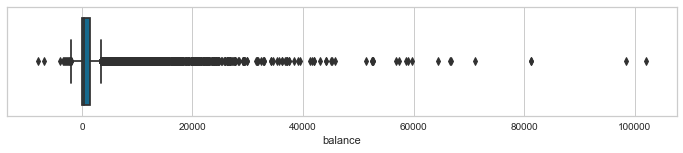

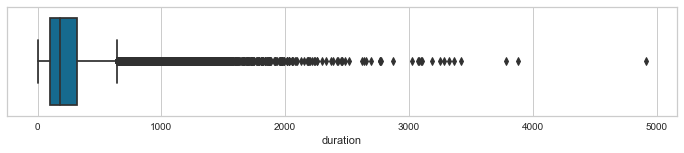

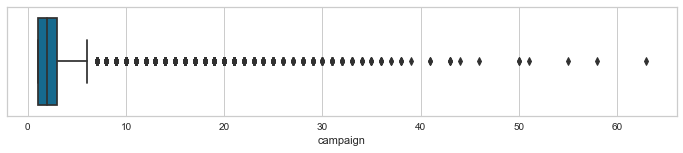

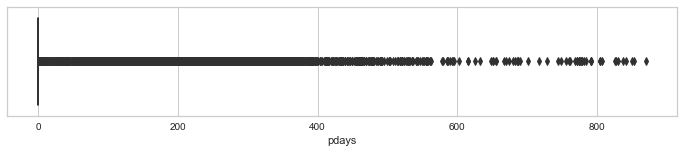

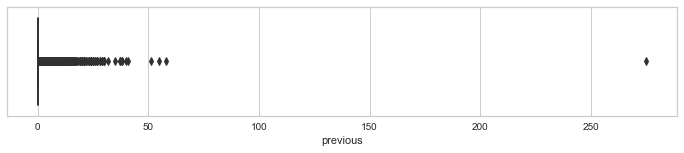

In [5]:
plt.figure(figsize=(12,2))
sns.boxplot(x=df_BankMarketingData.balance)
plt.figure(figsize=(12,2))
sns.boxplot(x=df_BankMarketingData.duration)
plt.figure(figsize=(12,2))
sns.boxplot(x=df_BankMarketingData.campaign)
plt.figure(figsize=(12,2))
sns.boxplot(x=df_BankMarketingData.pdays)
plt.figure(figsize=(12,2))
sns.boxplot(x=df_BankMarketingData.previous)

All the variables are right skewed with large numbers of outliers, and this is especially evident in the case of 'pdays' and 'previous' as was noted in the analysis above. In the case of 'pdays' the distorting effect of -1 being used to represent a category, and it being the most commonly observed category, is also apparent. Of note is the single extreme outlier in the 'previous' variable, which is the observation of 275 contacts with the customer before the campaign. This could indicate an error in the data (the maximum value is 275, and second highest observation in the range is 58), but we will already be binning this data so the outlier will not be separately treated.

###  
### Deliverable 1.1(b) - Strategies to address data challenges

The detailed analysis above includes a number of strategies to address challenges in the dataset.

#### Data pollution
The **contact** variable - as noted above, this is a categorical variable with only three categories, one of which is 'unknown'. According to the project brief, 'contact' records the communication type for the previous contact, so 'unknown' should not be present in the data. Compounding the issue is that 28.8% of the observations are in the 'unknown' category - this suggests the data in this variable is of low quality, with the communication type either not being captured at the point of contact, or a subsequent issue that has caused the data to be lost. The other two categories are 'cellular' and 'telephone', so imputing 'unknown', which is 28.8% of the data, to be either one of these risks introducing significant bias. In practice, this would be raised as a data quality issue with the customer who may want to take corrective action, or impute another category. For the purposes of this analysis, although this variable may turn out to be mathematically significant in the models, given it is of poor quality from a business perspective ("unknown" does not give actionable advice to the business) the strategy for this analysis will be to drop the variable.

#### Outliers
The detailed analysis and focus points above elaborate on the presence of outliers in the variables balance, duration, campaign, pdays, and previous. All of these will be binned and used as categorical variables.

#### Missing values
There are no missing values to impute in the data, however there are two variables that contain 'unknown' as observations - education, and poutcome. In the case of the education variable one strategy might be to impute the 'unknown' observations as being the most commonly observed class ('secondary'), however as it's a small percentage of the data and to avoid introducing bias toward secondary education, no values will be imputed. In the case of the poutcome variable, the detailed analysis above shows that this does not indicate an error in the data or missing observations, but it is the business outcome of not having contacted the customer, as shown in the pdays and previous observations.

#### Others
Also noted in the detailed analysis above is the default variable, which records whether the customer has credit in default. As noted, nearly all the observations (44396 or 98.2%) belong to the "no" class, so this is not going to be a useful variable - a "no" observation for default predicts every other combination. As such, for the purposes of this analysis the default variable will be dropped.

Before moving to multivariate analysis, we'll quickly confirm the conclusions about missing values by explicitly checking nulls for all columns.

In [6]:
df_BankMarketingData.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

##  
---
## Deliverable 1.2 - Multivariate analysis

### Deliverable 1.2(a) - Bi-variate analysis between predictor variables and target column

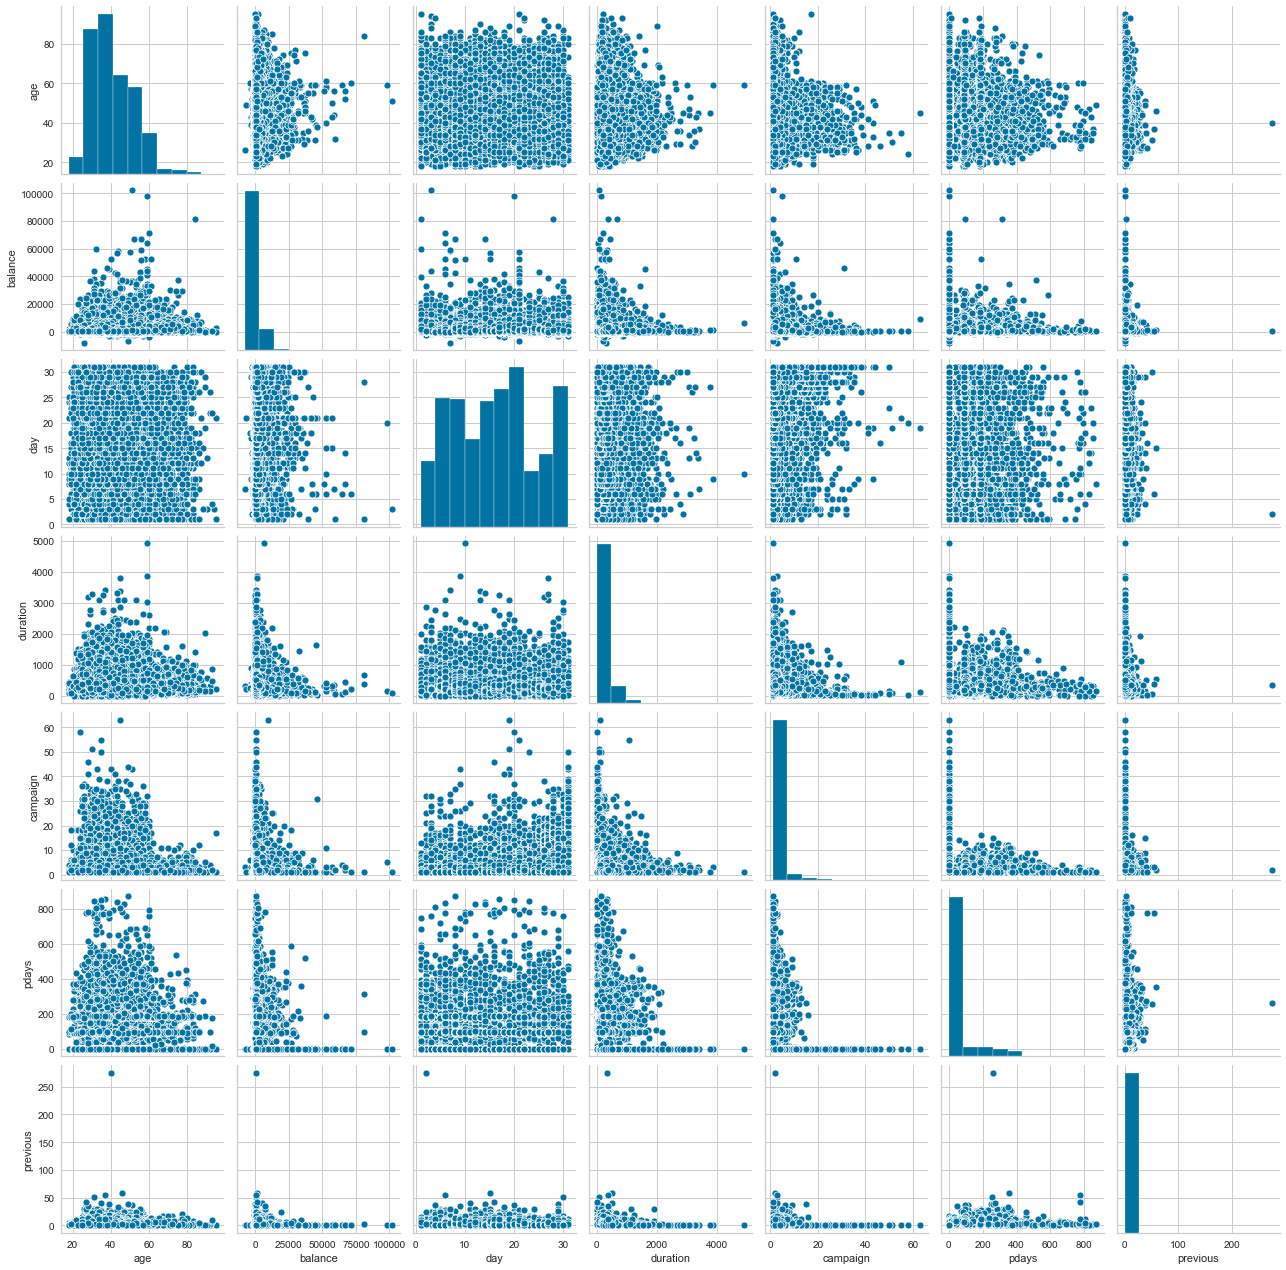

In [7]:
sns.pairplot(df_BankMarketingData);

No linear relationships are apparent between the variables. The highly right skewed distributions of balance, duration, campaign, pdays, and previous are discussed at length along with treatment strategies in the univariate analysis above.

Grouping the continuous variables by 'Target' (whether the customer subscribed for a term deposit) provides an opportunity to observe any patterns in the mean and media for each continuous variable grouped by whether the customer subscribed for a term deposit.

In [8]:
df_BankMarketingData.groupby(['Target']).agg(['mean','median']).transpose()

Target                    no          yes
age      mean      40.838986    41.670070
         median    39.000000    38.000000
balance  mean    1303.714969  1804.267915
         median   417.000000   733.000000
day      mean      15.892290    15.158253
         median    16.000000    15.000000
duration mean     221.182806   537.294574
         median   164.000000   426.000000
campaign mean       2.846350     2.141047
         median     2.000000     2.000000
pdays    mean      36.421372    68.702968
         median    -1.000000    -1.000000
previous mean       0.502154     1.170354
         median     0.000000     0.000000

Two observations of note are that the mean and median balances are higher for customers who have subscribed for a term deposit. Also, the mean and median duration of the last contact call are higher for customers who subscribed to a term deposit.

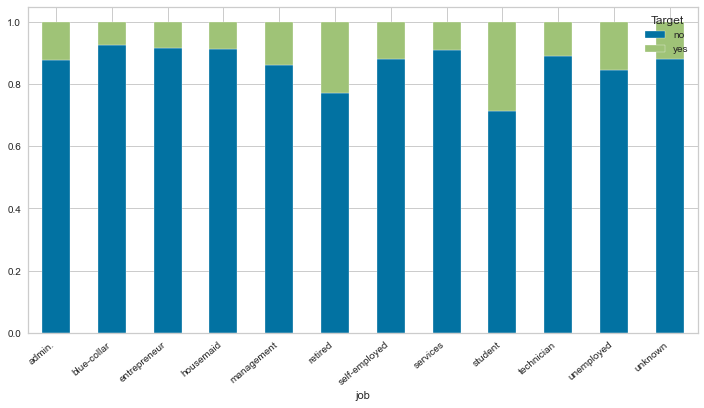

In [9]:
dva = pd.crosstab(df_BankMarketingData['job'], df_BankMarketingData['Target'])
ax = dva.div(dva.sum(1).astype(float), axis = 0).plot(kind='bar', stacked=True, figsize=(12,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

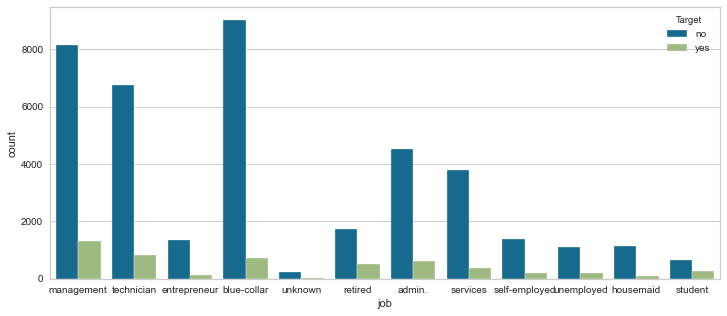

In [10]:
plt.figure(figsize=(12,5))
sns.countplot(x='job',hue='Target',data=df_BankMarketingData)

Customers who are students or retired have proportionally signed up at a higher rate than other job types, however their overall rate of response is lower.

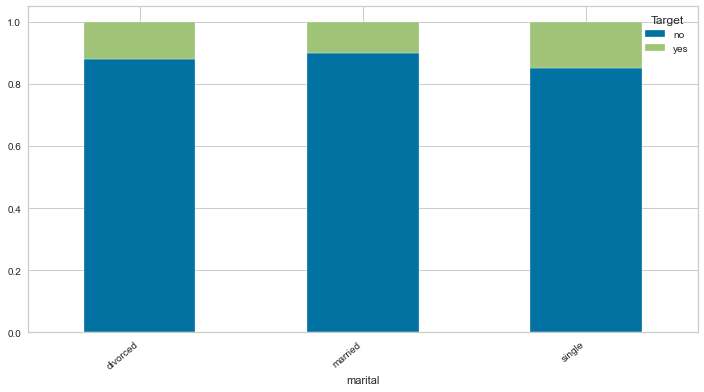

In [11]:
dva = pd.crosstab(df_BankMarketingData['marital'], df_BankMarketingData['Target'])
ax = dva.div(dva.sum(1).astype(float), axis = 0).plot(kind='bar', stacked=True, figsize=(12,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

Marital status does not appear to significantly change the rate at which customers subscribed to a term deposit.

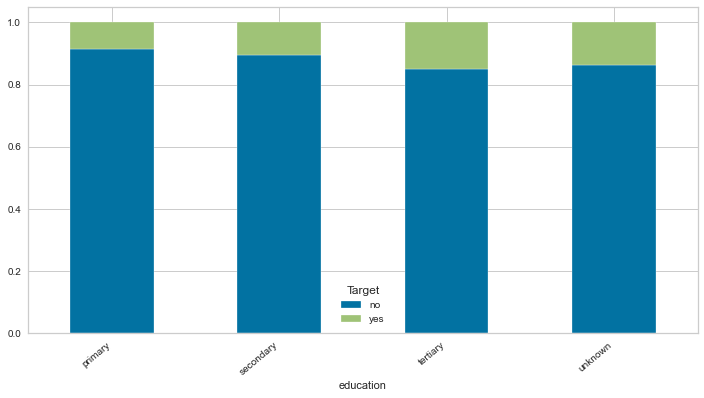

In [12]:
dva = pd.crosstab(df_BankMarketingData['education'], df_BankMarketingData['Target'])
ax = dva.div(dva.sum(1).astype(float), axis = 0).plot(kind='bar', stacked=True, figsize=(12,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

Customers with a tertiary level of education appear to accept term deposits at a slightly higher rate than other education levels.

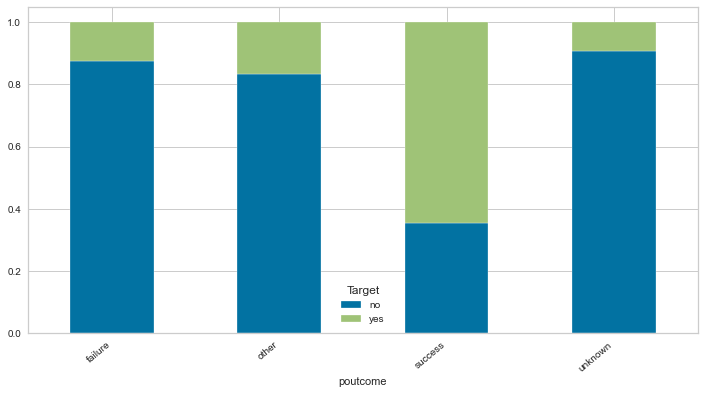

In [13]:
dva = pd.crosstab(df_BankMarketingData['poutcome'], df_BankMarketingData['Target'])
ax = dva.div(dva.sum(1).astype(float), axis = 0).plot(kind='bar', stacked=True, figsize=(12,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

More than half the customers for whom the previous campaign was a success have subscribed to term deposits, compared with less than 20% for the other campaign outcomes.

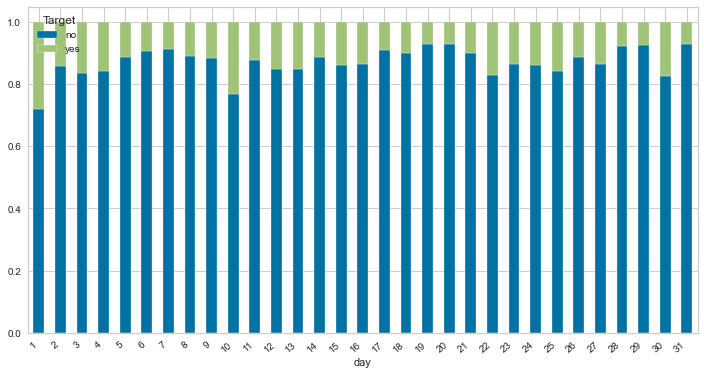

In [14]:
dva = pd.crosstab(df_BankMarketingData['day'], df_BankMarketingData['Target'])
ax = dva.div(dva.sum(1).astype(float), axis = 0).plot(kind='bar', stacked=True, figsize=(12,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

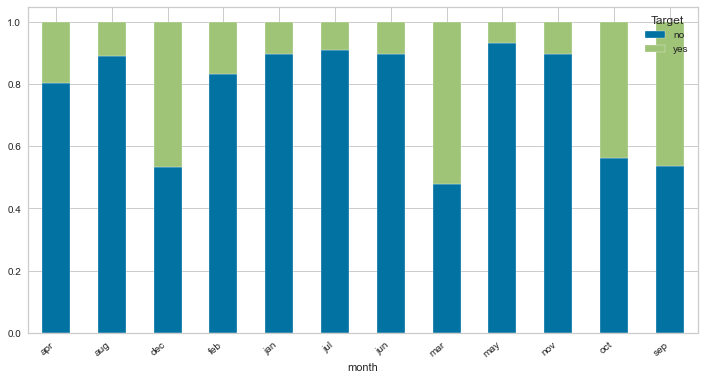

In [15]:
dva = pd.crosstab(df_BankMarketingData['month'], df_BankMarketingData['Target'])
ax = dva.div(dva.sum(1).astype(float), axis = 0).plot(kind='bar', stacked=True, figsize=(12,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

Customers who were last contacted in the months of March, September, October, and December appear to have subscribed to term deposits at a higher rate than customers last contacted in other months.

#  
---
# Deliverable 2 (prepare data for analytics)
---

## Deliverable 2.1 - Attribute types

In [16]:
df_ForAnalysis = df_BankMarketingData.copy()

# Drop contact and default, as per analysis and outcomes in Deliverable 1
df_ForAnalysis.drop(['contact', 'default'], axis=1, inplace=True)

# Convert housing, loan, and target to boolean values, and then to categorical type
df_ForAnalysis.housing.replace(to_replace=['no', 'yes'], value=[0, 1], inplace=True)
df_ForAnalysis.loan.replace(to_replace=['no', 'yes'], value=[0, 1], inplace=True)
df_ForAnalysis.Target.replace(to_replace=['no', 'yes'], value=[0, 1], inplace=True)

df_ForAnalysis['housing'] = df_ForAnalysis['housing'].astype('category')
df_ForAnalysis['loan'] = df_ForAnalysis['loan'].astype('category')
df_ForAnalysis['Target'] = df_ForAnalysis['Target'].astype('category')

In [17]:
df_ForAnalysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  object  
 2   marital    45211 non-null  object  
 3   education  45211 non-null  object  
 4   balance    45211 non-null  int64   
 5   housing    45211 non-null  category
 6   loan       45211 non-null  category
 7   day        45211 non-null  int64   
 8   month      45211 non-null  object  
 9   duration   45211 non-null  int64   
 10  campaign   45211 non-null  int64   
 11  pdays      45211 non-null  int64   
 12  previous   45211 non-null  int64   
 13  poutcome   45211 non-null  object  
 14  Target     45211 non-null  category
dtypes: category(3), int64(7), object(5)
memory usage: 4.3+ MB


## Deliverable 2.1 - Observations

As per the strategies outlined in the analysis in deliverable 1, the variables contact and default have been dropped, and the yes/no values have been explicitly converted to booleans and the corresponding variables converted to the category datatype. We're ready to prepare the data with the binning strategy.

##  
---
## Deliverable 2.2 - Prepare the data model

### Binning

In [18]:
# Bin the balance variable

def balance_bin(series):
    if series < 0: return "negative"
    elif 0 <= series < 500: return "low"
    elif 500 <= series < 2500: return "moderate"
    elif 2500 <= series < 10000: return "high"
    elif 10000 <= series: return "very high"
    
df_ForAnalysis['balance_bin'] = df_ForAnalysis['balance'].apply(balance_bin)
df_ForAnalysis['balance_bin'].value_counts()

low          19871
moderate     14697
high          6048
negative      3766
very high      829
Name: balance_bin, dtype: int64

In [19]:
# Bin the duration variable

def duration_bin(series):
    if series < 120: return "less than 2 minutes"
    elif 120 <= series < 300: return "2-5 minutes"
    elif 300 <= series < 600: return "5-10 minutes"
    elif 600 <= series : return "more than 10 minutes"

df_ForAnalysis['duration_bin'] = df_ForAnalysis['duration'].apply(duration_bin)
df_ForAnalysis['duration_bin'].value_counts()

2-5 minutes             18974
less than 2 minutes     13908
5-10 minutes             8527
more than 10 minutes     3802
Name: duration_bin, dtype: int64

In [20]:
# Bin the campaign variable

def campaign_bin(series):
    if series <= 2: return "1-2 contacts"
    elif 2 < series <= 5: return "3-5 contacts"
    elif 5 < series <= 10: return "6-10 contacts"
    elif 10 < series : return "more than 10 contacts"
    
df_ForAnalysis['campaign_bin'] = df_ForAnalysis['campaign'].apply(campaign_bin)
df_ForAnalysis['campaign_bin'].value_counts()

1-2 contacts             30049
3-5 contacts             10807
6-10 contacts             3159
more than 10 contacts     1196
Name: campaign_bin, dtype: int64

In [21]:
# Bin the pdays variable

def pdays_bin(series):
    if series == -1: return "no contact or over 900 days"
    elif 0 < series <= 31: return "in the last month"
    elif 31 < series <= 182: return "in the last six months"
    elif 182 < series <= 365: return "in the last year"
    elif 365 < series : return "more than one year"

df_ForAnalysis['pdays_bin'] = df_ForAnalysis['pdays'].apply(pdays_bin)
df_ForAnalysis['pdays_bin'].value_counts()

no contact or over 900 days    36954
in the last year                4132
in the last six months          3289
more than one year               643
in the last month                193
Name: pdays_bin, dtype: int64

In [22]:
# Bin the previous variable

def previous_bin(series):
    if series == 0: return "no contact"
    elif 1 <= series <= 2: return "1-2 contacts"
    elif 3 <= series <= 5: return "3-5 contacts"
    elif 5 < series : return "more than 5 contacts"

df_ForAnalysis['previous_bin'] = df_ForAnalysis['previous'].apply(previous_bin)
df_ForAnalysis['previous_bin'].value_counts()

no contact              36954
1-2 contacts             4878
3-5 contacts             2315
more than 5 contacts     1064
Name: previous_bin, dtype: int64

In [23]:
# Bin the day variable

def day_bin(series):
    if 1 <= series <= 8: return "first week"
    elif 9 <= series <= 16: return "second week"
    elif 17 <= series <= 24: return "third week"
    elif 25 <= series <= 31 : return "fourth week"
    
df_ForAnalysis['day_bin'] = df_ForAnalysis['day'].apply(day_bin)
df_ForAnalysis['day_bin'].value_counts()

third week     13073
second week    11718
first week     11640
fourth week     8780
Name: day_bin, dtype: int64

In [24]:
# Replace the month variables with calendar quarters

def month_bin(series):
    if series in ['jan', 'feb', 'mar']: return "first quarter"
    elif series in ['apr', 'may', 'jun']: return "second quarter"
    elif series in ['jul', 'aug', 'sep']: return "third quarter"
    elif series in ['oct', 'nov', 'dec']: return "fourth quarter"
    
df_ForAnalysis['month_bin'] = df_ForAnalysis['month'].apply(month_bin)
df_ForAnalysis['month_bin'].value_counts()

second quarter    22039
third quarter     13721
fourth quarter     4922
first quarter      4529
Name: month_bin, dtype: int64

In [25]:
# Drop all the binned columns
df_ForAnalysis.drop(['balance', 'duration', 'campaign', 'pdays', 'previous', 'day', 'month'], axis=1, inplace=True)

In [26]:
df_ForAnalysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           45211 non-null  int64   
 1   job           45211 non-null  object  
 2   marital       45211 non-null  object  
 3   education     45211 non-null  object  
 4   housing       45211 non-null  category
 5   loan          45211 non-null  category
 6   poutcome      45211 non-null  object  
 7   Target        45211 non-null  category
 8   balance_bin   45211 non-null  object  
 9   duration_bin  45211 non-null  object  
 10  campaign_bin  45211 non-null  object  
 11  pdays_bin     45211 non-null  object  
 12  previous_bin  45211 non-null  object  
 13  day_bin       45211 non-null  object  
 14  month_bin     45211 non-null  object  
dtypes: category(3), int64(1), object(11)
memory usage: 4.3+ MB


## Deliverable 2.2 - Observations

All the variables that showed high skewness and large numbers of outliers have been binned are ready to convert to categorical variables. The boolean variables have been prepared, and all variables are now in the correct state to build the models.

##  
---
## Deliverable 2.3 - Transformations

In [27]:
# Prepare the X & Y datasets for the target variable 'Target'
# One hot encode all the categorical variables - including all the new binned variables

X = df_ForAnalysis.drop(labels=['Target'], axis=1)
Y = df_ForAnalysis[['Target']]

X = pd.get_dummies(X, columns=['job', 'marital', 'education', 'poutcome', 'balance_bin', 'duration_bin', 'campaign_bin', 'pdays_bin', 'previous_bin', 'day_bin', 'month_bin'], drop_first=True)



In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 45 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   age                                    45211 non-null  int64   
 1   housing                                45211 non-null  category
 2   loan                                   45211 non-null  category
 3   job_blue-collar                        45211 non-null  uint8   
 4   job_entrepreneur                       45211 non-null  uint8   
 5   job_housemaid                          45211 non-null  uint8   
 6   job_management                         45211 non-null  uint8   
 7   job_retired                            45211 non-null  uint8   
 8   job_self-employed                      45211 non-null  uint8   
 9   job_services                           45211 non-null  uint8   
 10  job_student                            45211 non-null  uin

## Deliverable 2.3 - Observations

After one hot encoding there are now 45 features that will be used to produce the models.

##  
---
## Deliverable 2.4 - Create training and test datasets (70:30 split)

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30,random_state=1)

In [30]:
print("{0:0.2f}% data is in the Training set".format((len(X_train)/len(df_ForAnalysis.index)) * 100))
print("{0:0.2f}% data is in the Test set".format((len(X_test)/len(df_ForAnalysis.index)) * 100))

70.00% data is in the Training set
30.00% data is in the Test set


In [31]:
print("Original Target True Values    : {0} ({1:0.2f}%)".format(len(df_ForAnalysis.loc[df_ForAnalysis['Target'] == 1]), (len(df_ForAnalysis.loc[df_ForAnalysis['Target'] == 1])/len(df_ForAnalysis.index)) * 100))
print("Original Target False Values   : {0} ({1:0.2f}%)".format(len(df_ForAnalysis.loc[df_ForAnalysis['Target'] == 0]), (len(df_ForAnalysis.loc[df_ForAnalysis['Target'] == 0])/len(df_ForAnalysis.index)) * 100))
print("")
print("Training Target True Values    : {0} ({1:0.2f}%)".format(len(Y_train.loc[Y_train['Target'] == 1]), (len(Y_train.loc[Y_train['Target'] == 1])/len(Y_train.index)) * 100))
print("Training Target False Values   : {0} ({1:0.2f}%)".format(len(Y_train.loc[Y_train['Target'] == 0]), (len(Y_train.loc[Y_train['Target'] == 0])/len(Y_train.index)) * 100))
print("")
print("Testing Target True Values    : {0} ({1:0.2f}%)".format(len(Y_test.loc[Y_test['Target'] == 1]), (len(Y_test.loc[Y_test['Target'] == 1])/len(Y_test.index)) * 100))
print("Testing Target False Values   : {0} ({1:0.2f}%)".format(len(Y_test.loc[Y_test['Target'] == 0]), (len(Y_test.loc[Y_test['Target'] == 0])/len(Y_test.index)) * 100))
print("")

Original Target True Values    : 5289 (11.70%)
Original Target False Values   : 39922 (88.30%)

Training Target True Values    : 3738 (11.81%)
Training Target False Values   : 27909 (88.19%)

Testing Target True Values    : 1551 (11.43%)
Testing Target False Values   : 12013 (88.57%)



## Deliverable 2.4 - Observations

The splits have preserved the same balance in the target variable. Note also that the target variable is highly imbalanced.

#  
---
# Deliverable 3 (create the ensemble model)
---

## Deliverable 3.1 - Logistic Regression and Decision Tree models

### Prepare

In [32]:
# Define a function to draw confusion matrices

def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()
    
# Create a dataframe to record results for each model
df_ModelComparison = pd.DataFrame(columns=['Model', 'Train Score', 'Test Score', 'Recall', 'Precision', 'F1 Score', 'ROC AUC Score'])

# Set a constant random_state to use for all models, and class_weight of 'balanced', as the target
# variable 'Target' is highly imbalanced
random_state = [30]
class_weight = ['balanced']

### Logistic Regression

Confusion Matrix


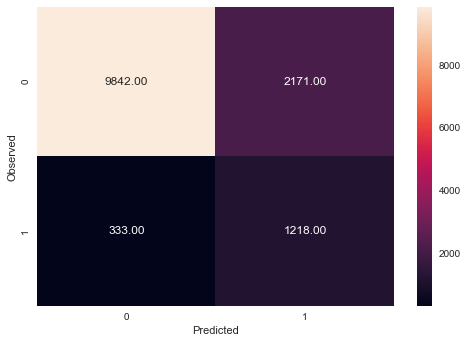

None
{'C': 0.01,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 30,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


Model  Train Score  Test Score  Recall  Precision  F1 Score  \
0  Logistic Regression      0.81749     0.81539 0.78530    0.35940   0.49312   

   ROC AUC Score  
0        0.80229

In [33]:
# Run GridSearchCV to find the best parameters for the LogisticRegression
# The target variable 'Target' is imbalanced, so using class_weight balanced

# Logistic regression with CV, we have an imbalanced target variable, so using balanced class weight
penalty = ['l1', 'l2', 'elasticnet']
C = [0.01, 0.1, 0.25, 0.5, 0.75, 1]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
hyperparameters = dict(random_state=random_state, C=C, penalty=penalty, solver=solver, class_weight=class_weight)

logistic = LogisticRegression()
logreg_TermDeposit = GridSearchCV(logistic, hyperparameters)
logreg_TermDeposit.fit(X_train, Y_train)
Y_predict = logreg_TermDeposit.predict(X_test)

print('Confusion Matrix')
print(draw_cm(Y_test,Y_predict))

pprint(logreg_TermDeposit.best_estimator_.get_params())

train_score = round(logreg_TermDeposit.score(X_train,Y_train), 5)
test_score = round(logreg_TermDeposit.score(X_test, Y_test), 5)
recall = round(recall_score(Y_test,Y_predict), 5)
precision = round(precision_score(Y_test,Y_predict), 5)
f1score = round(f1_score(Y_test,Y_predict), 5)
rocauc_score = round(roc_auc_score(Y_test,Y_predict), 5)

df_ModelComparison.loc[0] = ['Logistic Regression', train_score, test_score, recall, precision, f1score, rocauc_score]
pd.options.display.float_format = "{:.5f}".format
df_ModelComparison

Logisitic Regression with hyperparameter tuning produces a model that does not show over or under fitting, with train and test scores of 0.817 and 0.815 respectively. Also, the Recall score of 0.785 suits the business need for this model, which is for the bank to reduce the false negative predictions (customers who would subscribe for a term deposit, but were not offered one), versus the negligible cost of offering a term deposit to a customer who does not take up the offer.

### Decision Tree

Confusion Matrix


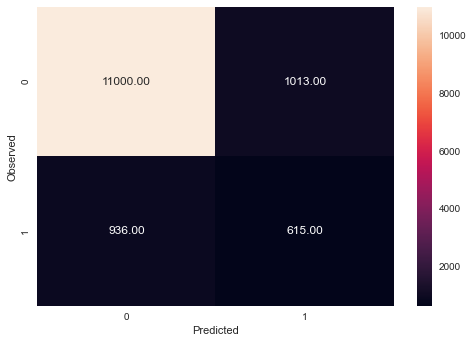

None
{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 50,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 30,
 'splitter': 'best'}


Model  Train Score  Test Score  Recall  Precision  F1 Score  \
0  Logistic Regression      0.81749     0.81539 0.78530    0.35940   0.49312   
1        Decision Tree      0.99754     0.85631 0.39652    0.37776   0.38691   

   ROC AUC Score  
0        0.80229  
1        0.65610

In [34]:
max_depth = np.arange(10, 200, 10)
criterion = ['entropy', 'gini']
hyperparameters = dict(random_state=random_state, max_depth=max_depth, criterion=criterion, class_weight=class_weight)

decisiontree = DecisionTreeClassifier()
dectree_TermDeposit = GridSearchCV(decisiontree, hyperparameters)
dectree_TermDeposit.fit(X_train, Y_train)
Y_predict = dectree_TermDeposit.predict(X_test)

print('Confusion Matrix')
print(draw_cm(Y_test,Y_predict))

pprint(dectree_TermDeposit.best_estimator_.get_params())

train_score = round(dectree_TermDeposit.score(X_train,Y_train), 5)
test_score = round(dectree_TermDeposit.score(X_test, Y_test), 5)
recall = round(recall_score(Y_test,Y_predict), 5)
precision = round(precision_score(Y_test,Y_predict), 5)
f1score = round(f1_score(Y_test,Y_predict), 5)
rocauc_score = round(roc_auc_score(Y_test,Y_predict), 5)

df_ModelComparison.loc[1] = ['Decision Tree', train_score, test_score, recall, precision, f1score, rocauc_score]
pd.options.display.float_format = "{:.5f}".format
df_ModelComparison.sort_values(by=['ROC AUC Score', 'Recall'], ascending=False, inplace=True)
df_ModelComparison.reset_index(drop=True,inplace=True)
df_ModelComparison

The entropy criterion with a max_depth of 50 produced the best result in the grid search. As expected, the Decision Tree result shows overfitting with a train score of 0.99 but a test score of 0.85. The model performed better than Logistic Regression on precision, however on the key metric that aligns with the business need (recall) the model performed significantly worse than the Logistic Regression model.

For comparison, we'll prune the model to a max_depth of 10 and compare the scores.

Confusion Matrix


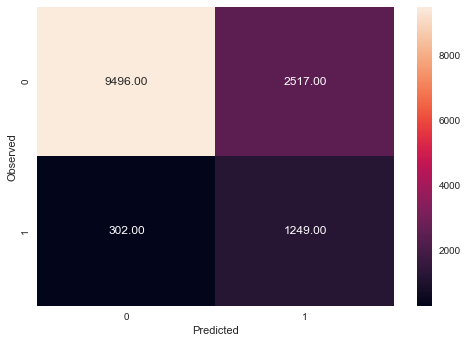

None


Model  Train Score  Test Score  Recall  Precision  \
0     Logistic Regression      0.81749     0.81539 0.78530    0.35940   
1  Decision Tree - Pruned      0.80826     0.79217 0.80529    0.33165   
2           Decision Tree      0.99754     0.85631 0.39652    0.37776   

   F1 Score  ROC AUC Score  
0   0.49312        0.80229  
1   0.46981        0.79788  
2   0.38691        0.65610

In [35]:
max_depth = 10
criterion = dectree_TermDeposit.best_estimator_.get_params()['criterion']

dectree_TermDeposit_pruned = DecisionTreeClassifier(random_state=random_state[0], criterion=criterion, max_depth=max_depth, class_weight=class_weight[0])
dectree_TermDeposit_pruned.fit(X_train, Y_train)
Y_predict = dectree_TermDeposit_pruned.predict(X_test)

print('Confusion Matrix')
print(draw_cm(Y_test,Y_predict))

train_score = round(dectree_TermDeposit_pruned.score(X_train,Y_train), 5)
test_score = round(dectree_TermDeposit_pruned.score(X_test, Y_test), 5)
recall = round(recall_score(Y_test,Y_predict), 5)
precision = round(precision_score(Y_test,Y_predict), 5)
f1score = round(f1_score(Y_test,Y_predict), 5)
rocauc_score = round(roc_auc_score(Y_test,Y_predict), 5)

df_ModelComparison.loc[2] = ['Decision Tree - Pruned', train_score, test_score, recall, precision, f1score, rocauc_score]
pd.options.display.float_format = "{:.5f}".format
df_ModelComparison.sort_values(by=['ROC AUC Score', 'Recall'], ascending=False, inplace=True)
df_ModelComparison.reset_index(drop=True,inplace=True)
df_ModelComparison

## Deliverable 3.1 - Observations

Pruning the Decision Tree model to max_depth of 10 means the model is now only slightly overfit, and is now performing very close to the Logistic Regression model, with a slightly lower ROC AUC score, but a higher recall of 0.805.

##  
---
## Deliverable 3.2 - Ensemble models

### Random Forest

Confusion Matrix


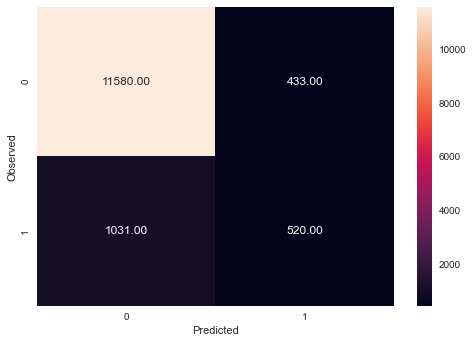

None
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}


Model  Train Score  Test Score  Recall  Precision  \
0     Logistic Regression      0.81749     0.81539 0.78530    0.35940   
1  Decision Tree - Pruned      0.80826     0.79217 0.80529    0.33165   
2           Decision Tree      0.99754     0.85631 0.39652    0.37776   
3           Random Forest      0.99757     0.89207 0.33527    0.54565   

   F1 Score  ROC AUC Score  
0   0.49312        0.80229  
1   0.46981        0.79788  
2   0.38691        0.65610  
3   0.41534        0.64961

In [36]:
n_estimators = [50, 100, 200]
criterion = ['entropy', 'gini']
hyperparameters = dict(random_state=random_state, n_estimators=n_estimators, criterion=criterion, class_weight=class_weight)

randomforest = RandomForestClassifier()
randfor_TermDeposit = GridSearchCV(randomforest, hyperparameters)
randfor_TermDeposit.fit(X_train, Y_train)
Y_predict = randfor_TermDeposit.predict(X_test)

print('Confusion Matrix')
print(draw_cm(Y_test,Y_predict))

pprint(randfor_TermDeposit.best_estimator_.get_params())

train_score = round(randfor_TermDeposit.score(X_train,Y_train), 5)
test_score = round(randfor_TermDeposit.score(X_test, Y_test), 5)
recall = round(recall_score(Y_test,Y_predict), 5)
precision = round(precision_score(Y_test,Y_predict), 5)
f1score = round(f1_score(Y_test,Y_predict), 5)
rocauc_score = round(roc_auc_score(Y_test,Y_predict), 5)

df_ModelComparison.loc[3] = ['Random Forest', train_score, test_score, recall, precision, f1score, rocauc_score]
pd.options.display.float_format = "{:.5f}".format
df_ModelComparison.sort_values(by=['ROC AUC Score', 'Recall'], ascending=False, inplace=True)
df_ModelComparison.reset_index(drop=True,inplace=True)
df_ModelComparison

Pruning the max_depth while using the best estimated criterion and n_estimators may help address the overfitting still in the model.

Confusion Matrix


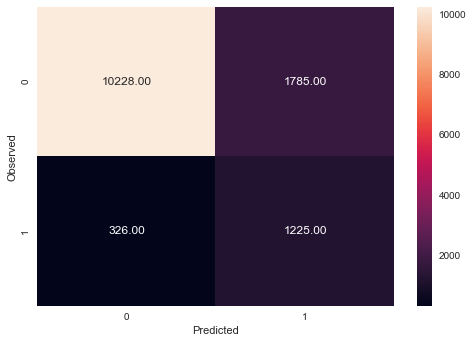

None


Model  Train Score  Test Score  Recall  Precision  \
0  Random Forest - Pruned      0.80826     0.79217 0.78981    0.40698   
1     Logistic Regression      0.81749     0.81539 0.78530    0.35940   
2  Decision Tree - Pruned      0.80826     0.79217 0.80529    0.33165   
3           Decision Tree      0.99754     0.85631 0.39652    0.37776   
4           Random Forest      0.99757     0.89207 0.33527    0.54565   

   F1 Score  ROC AUC Score  
0   0.53716        0.82061  
1   0.49312        0.80229  
2   0.46981        0.79788  
3   0.38691        0.65610  
4   0.41534        0.64961

In [37]:
max_depth = 10
criterion = randfor_TermDeposit.best_estimator_.get_params()['criterion']
n_estimators = randfor_TermDeposit.best_estimator_.get_params()['n_estimators']

randfor_TermDeposit_pruned = RandomForestClassifier(random_state=random_state[0], n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, class_weight=class_weight[0])
randfor_TermDeposit_pruned.fit(X_train, Y_train)
Y_predict = randfor_TermDeposit_pruned.predict(X_test)

print('Confusion Matrix')
print(draw_cm(Y_test,Y_predict))

train_score = round(dectree_TermDeposit_pruned.score(X_train,Y_train), 5)
test_score = round(dectree_TermDeposit_pruned.score(X_test, Y_test), 5)
recall = round(recall_score(Y_test,Y_predict), 5)
precision = round(precision_score(Y_test,Y_predict), 5)
f1score = round(f1_score(Y_test,Y_predict), 5)
rocauc_score = round(roc_auc_score(Y_test,Y_predict), 5)

df_ModelComparison.loc[4] = ['Random Forest - Pruned', train_score, test_score, recall, precision, f1score, rocauc_score]
pd.options.display.float_format = "{:.5f}".format
df_ModelComparison.sort_values(by=['ROC AUC Score', 'Recall'], ascending=False, inplace=True)
df_ModelComparison.reset_index(drop=True,inplace=True)
df_ModelComparison

### Boosting

Confusion Matrix


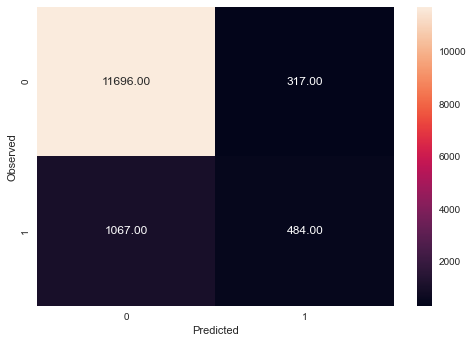

None
{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 30}


Model  Train Score  Test Score  Recall  Precision  \
0  Random Forest - Pruned      0.80826     0.79217 0.78981    0.40698   
1     Logistic Regression      0.81749     0.81539 0.78530    0.35940   
2  Decision Tree - Pruned      0.80826     0.79217 0.80529    0.33165   
3           Decision Tree      0.99754     0.85631 0.39652    0.37776   
4           Random Forest      0.99757     0.89207 0.33527    0.54565   
5                AdaBoost      0.89582     0.89797 0.31206    0.60424   

   F1 Score  ROC AUC Score  
0   0.53716        0.82061  
1   0.49312        0.80229  
2   0.46981        0.79788  
3   0.38691        0.65610  
4   0.41534        0.64961  
5   0.41156        0.64283

In [38]:
n_estimators = [50, 100, 200]
hyperparameters = dict(random_state=random_state, n_estimators=n_estimators)

adaboost = AdaBoostClassifier()
adaboost_TermDeposit = GridSearchCV(adaboost, hyperparameters)
adaboost_TermDeposit.fit(X_train, Y_train)
Y_predict = adaboost_TermDeposit.predict(X_test)

print('Confusion Matrix')
print(draw_cm(Y_test,Y_predict))

pprint(adaboost_TermDeposit.best_estimator_.get_params())

train_score = round(adaboost_TermDeposit.score(X_train,Y_train), 5)
test_score = round(adaboost_TermDeposit.score(X_test, Y_test), 5)
recall = round(recall_score(Y_test,Y_predict), 5)
precision = round(precision_score(Y_test,Y_predict), 5)
f1score = round(f1_score(Y_test,Y_predict), 5)
rocauc_score = round(roc_auc_score(Y_test,Y_predict), 5)

df_ModelComparison.loc[5] = ['AdaBoost', train_score, test_score, recall, precision, f1score, rocauc_score]
pd.options.display.float_format = "{:.5f}".format
df_ModelComparison.sort_values(by=['ROC AUC Score', 'Recall'], ascending=False, inplace=True)
df_ModelComparison.reset_index(drop=True,inplace=True)
df_ModelComparison

### Bagging

Confusion Matrix


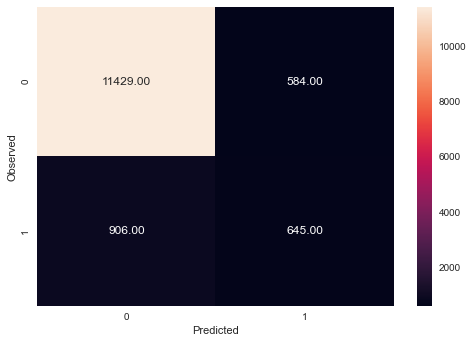

None
{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}


Model  Train Score  Test Score  Recall  Precision  \
0  Random Forest - Pruned      0.80826     0.79217 0.78981    0.40698   
1     Logistic Regression      0.81749     0.81539 0.78530    0.35940   
2  Decision Tree - Pruned      0.80826     0.79217 0.80529    0.33165   
3                 Bagging      0.99788     0.89015 0.41586    0.52482   
4           Decision Tree      0.99754     0.85631 0.39652    0.37776   
5           Random Forest      0.99757     0.89207 0.33527    0.54565   
6                AdaBoost      0.89582     0.89797 0.31206    0.60424   

   F1 Score  ROC AUC Score  
0   0.53716        0.82061  
1   0.49312        0.80229  
2   0.46981        0.79788  
3   0.46403        0.68362  
4   0.38691        0.65610  
5   0.41534        0.64961  
6   0.41156        0.64283

In [39]:
n_estimators = [50, 100, 200]
hyperparameters = dict(random_state=random_state, n_estimators=n_estimators)

bagging = BaggingClassifier()
bagging_TermDeposit = GridSearchCV(bagging, hyperparameters)
bagging_TermDeposit.fit(X_train, Y_train)
Y_predict = bagging_TermDeposit.predict(X_test)

print('Confusion Matrix')
print(draw_cm(Y_test,Y_predict))

pprint(bagging_TermDeposit.best_estimator_.get_params())

train_score = round(bagging_TermDeposit.score(X_train,Y_train), 5)
test_score = round(bagging_TermDeposit.score(X_test, Y_test), 5)
recall = round(recall_score(Y_test,Y_predict), 5)
precision = round(precision_score(Y_test,Y_predict), 5)
f1score = round(f1_score(Y_test,Y_predict), 5)
rocauc_score = round(roc_auc_score(Y_test,Y_predict), 5)

df_ModelComparison.loc[6] = ['Bagging', train_score, test_score, recall, precision, f1score, rocauc_score]
pd.options.display.float_format = "{:.5f}".format
df_ModelComparison.sort_values(by=['ROC AUC Score', 'Recall'], ascending=False, inplace=True)
df_ModelComparison.reset_index(drop=True,inplace=True)
df_ModelComparison

### GradientBoost

Confusion Matrix


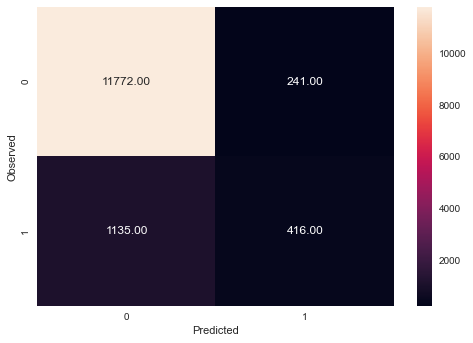

None
{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 30,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


Model  Train Score  Test Score  Recall  Precision  \
0  Random Forest - Pruned      0.80826     0.79217 0.78981    0.40698   
1     Logistic Regression      0.81749     0.81539 0.78530    0.35940   
2  Decision Tree - Pruned      0.80826     0.79217 0.80529    0.33165   
3                 Bagging      0.99788     0.89015 0.41586    0.52482   
4           Decision Tree      0.99754     0.85631 0.39652    0.37776   
5           Random Forest      0.99757     0.89207 0.33527    0.54565   
6                AdaBoost      0.89582     0.89797 0.31206    0.60424   
7           GradientBoost      0.89958     0.89855 0.26821    0.63318   

   F1 Score  ROC AUC Score  
0   0.53716        0.82061  
1   0.49312        0.80229  
2   0.46981        0.79788  
3   0.46403        0.68362  
4   0.38691        0.65610  
5   0.41534        0.64961  
6   0.41156        0.64283  
7   0.37681        0.62408

In [40]:
n_estimators = [50, 100, 200]
hyperparameters = dict(random_state=random_state, n_estimators=n_estimators)

gradientboost = GradientBoostingClassifier()
gradboost_TermDeposit = GridSearchCV(gradientboost, hyperparameters)
gradboost_TermDeposit.fit(X_train, Y_train)
Y_predict = gradboost_TermDeposit.predict(X_test)

print('Confusion Matrix')
print(draw_cm(Y_test,Y_predict))

pprint(gradboost_TermDeposit.best_estimator_.get_params())

train_score = round(gradboost_TermDeposit.score(X_train,Y_train), 5)
test_score = round(gradboost_TermDeposit.score(X_test, Y_test), 5)
recall = round(recall_score(Y_test,Y_predict), 5)
precision = round(precision_score(Y_test,Y_predict), 5)
f1score = round(f1_score(Y_test,Y_predict), 5)
rocauc_score = round(roc_auc_score(Y_test,Y_predict), 5)

df_ModelComparison.loc[7] = ['GradientBoost', train_score, test_score, recall, precision, f1score, rocauc_score]
pd.options.display.float_format = "{:.5f}".format
df_ModelComparison.sort_values(by=['ROC AUC Score', 'Recall'], ascending=False, inplace=True)
df_ModelComparison.reset_index(drop=True,inplace=True)
df_ModelComparison

## Deliverable 3.2 - Observations

All the models performed well on train scores, with overfitting observed in the bagging, decision tree, and random forest models. Pruning the decision tree and random forest improved the performance of the models, with the pruned random forest achieving an ROC AUC score of 0.82 and a Recall of 0.78. The best recall score was 0.80, observed for the decision tree. Of the other ensemble methods, bagging performed the best, although the model was still overfit. The boosting algorithms addressed the overfitting, but produced very low recall scores which would make them unsuitable for this business use case.

##  
---
## Deliverable 3.3 - Model comparisons

In [41]:
df_ModelComparison

Model  Train Score  Test Score  Recall  Precision  \
0  Random Forest - Pruned      0.80826     0.79217 0.78981    0.40698   
1     Logistic Regression      0.81749     0.81539 0.78530    0.35940   
2  Decision Tree - Pruned      0.80826     0.79217 0.80529    0.33165   
3                 Bagging      0.99788     0.89015 0.41586    0.52482   
4           Decision Tree      0.99754     0.85631 0.39652    0.37776   
5           Random Forest      0.99757     0.89207 0.33527    0.54565   
6                AdaBoost      0.89582     0.89797 0.31206    0.60424   
7           GradientBoost      0.89958     0.89855 0.26821    0.63318   

   F1 Score  ROC AUC Score  
0   0.53716        0.82061  
1   0.49312        0.80229  
2   0.46981        0.79788  
3   0.46403        0.68362  
4   0.38691        0.65610  
5   0.41534        0.64961  
6   0.41156        0.64283  
7   0.37681        0.62408

### Selected model - RandomForest with max_depth

#### Confusion matrix

Confusion Matrix


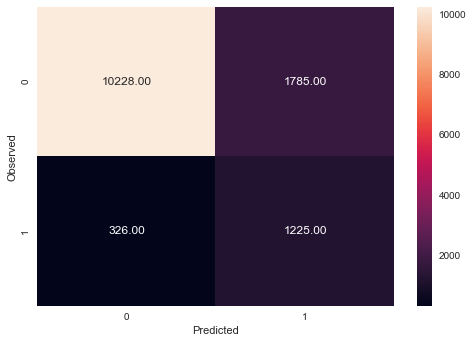

None


In [42]:
randfor_TermDeposit_pruned.fit(X_train, Y_train)
Y_predict = randfor_TermDeposit_pruned.predict(X_test)

print('Confusion Matrix')
print(draw_cm(Y_test,Y_predict))

#### Classification report and ROC curves

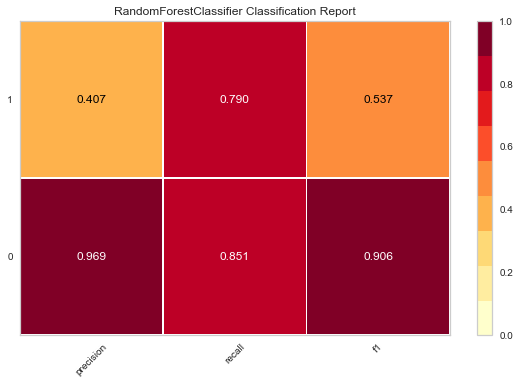

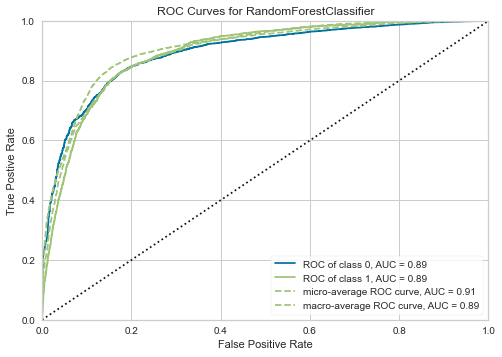

In [43]:
viz = ClassificationReport(randfor_TermDeposit_pruned)
viz.fit(X_train, Y_train)
viz.score(X_test, Y_test)
viz.show()

roc = ROCAUC(randfor_TermDeposit_pruned)
roc.fit(X_train, Y_train)
roc.score(X_test, Y_test)
roc.show()

## Deliverable 3.3 - Observations

Recalling the objective of this project, which is to identify customers who will are relatively more likely to subscribe to a term deposit, the objective is to produce models with the lowest recall - that is, models that produce the lowest false negative predictions. A false negative prediction is opportunity cost - it means a customer that would have subscribed to a term deposit is not contacted by the bank. Conversely, a false positive prediction has near zero cost - it means that the bank will contact a customer, and they will not take up the offer. When comparing these two outcomes, the one that reduces missed commercial opportunities is the one that meets the objective of this project. Accordingly, the results matrix for these models has been sorted first by ROC AUC Score as the best overall measure, and then by Recall.

#  
---
# 4 - Conclusions
---

Random Forest with max_depth produces the best model for this business requirement. The recall scores for the two prediction classes are high, and the ROC curves show the high AUC for each class.